# Modeling and Simulation in Python

Chapter 24

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Rolling paper

We'll start by loading the units we need.

In [2]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second

<Unit('second')>

And creating a `Params` object with the system parameters

In [3]:
params = Params(Rmin = 0.02 * m,
                Rmax = 0.055 * m,
                L = 47 * m,
                omega = 10 * radian / s,
                t_end = 130 * s,
                dt = 1*s)

,values
Rmin,0.02 meter
Rmax,0.055 meter
L,47 meter
omega,10.0 radian / second
t_end,130 second
dt,1 second


The following function estimates the parameter `k`, which is the increase in the radius of the roll for each radian of rotation. 

In [4]:
def estimate_k(params):
    """Estimates the parameter `k`.
    
    params: Params with Rmin, Rmax, and L
    
    returns: k in meters per radian
    """
    Rmin, Rmax, L = params.Rmin, params.Rmax, params.L
    
    Ravg = (Rmax + Rmin) / 2
    Cavg = 2 * pi * Ravg
    revs = L / Cavg
    rads = 2 * pi * revs
    k = (Rmax - Rmin) / rads
    return k

As usual, `make_system` takes a `Params` object and returns a `System` object.

In [5]:
def make_system(params):
    """Make a system object.
    
    params: Params with Rmin, Rmax, and L
    
    returns: System with init, k, and ts
    """
    init = State(theta = 0 * radian,
                 y = 0 * m,
                 r = params.Rmin)
    
    k = estimate_k(params)

    return System(params, init=init, k=k)

Testing `make_system`

In [6]:
system = make_system(params)

,values
Rmin,0.02 meter
Rmax,0.055 meter
L,47 meter
omega,10.0 radian / second
t_end,130 second
dt,1 second
init,theta 0 radian y 0 meter r ...
k,2.7925531914893616e-05 meter


In [7]:
system.init

,values
theta,0 radian
y,0 meter
r,0.02 meter


Now we can write a slope function based on the differential equations

$\omega = \frac{d\theta}{dt} = 10$

$\frac{dy}{dt} = r \frac{d\theta}{dt}$

$\frac{dr}{dt} = k \frac{d\theta}{dt}$


In [8]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: sequence of derivatives
    """
    theta, y, r = state
    k, omega = system.k, system.omega
    
    dydt = r * omega
    drdt = k * omega
    
    return omega, dydt, drdt

Testing `slope_func`

In [9]:
slope_func(system.init, 0, system)

(10.0 <Unit('radian / second')>,
 0.2 <Unit('meter * radian / second')>,
 0.0002792553191489362 <Unit('meter * radian / second')>)

We'll use an event function to stop when `y=L`.

In [10]:
def event_func(state, t, system):
    """Detects when we've rolled length `L`.
    
    state: State object with theta, y, r
    t: time
    system: System object with L
    
    returns: difference between `y` and `L`
    """
    theta, y, r = state
    
    return y - system.L

In [11]:
event_func(system.init, 0, system)

-47 <Unit('meter')>

Now we can run the simulation.

In [12]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
success,True
message,A termination event occurred.


And look at the results.

In [13]:
results.tail()

,theta,y,r
122.00000,1220.0 radian,45.18218085106379 meter,0.05406914893617014 meter
123.00000,1230.0 radian,45.72426861702124 meter,0.054348404255319074 meter
124.00000,1240.0 radian,46.269148936170176 meter,0.05462765957446801 meter
125.00000,1250.0 radian,46.8168218085106 meter,0.054906914893616945 meter
125.33277,1253.3276965817133 radian,47.0 meter,0.054999842590712666 meter


The final value of `y` is 47 meters, as expected.

In [14]:
unrolled = get_last_value(results.y)

47.0 <Unit('meter')>

The final value of radius is `R_max`.

In [15]:
radius = get_last_value(results.r)

0.054999842590712666 <Unit('meter')>

The total number of rotations is close to 200, which seems plausible.

In [16]:
radians = get_last_value(results.theta) 
rotations = magnitude(radians) / 2 / np.pi

199.47329822495885

The elapsed time is about 2 minutes, which is also plausible.

In [17]:
t_final = get_last_label(results) * s

125.33276965817134 <Unit('second')>

### Plotting

Plotting `theta`

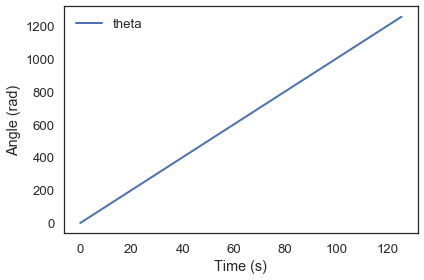

In [18]:
def plot_theta(results):
    plot(results.theta, color='C0', label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

Plotting `y`

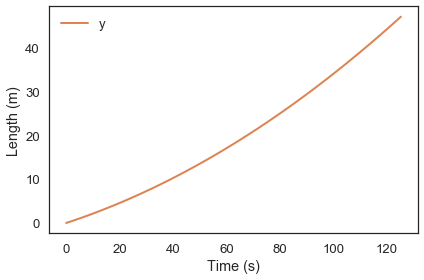

In [19]:
def plot_y(results):
    plot(results.y, color='C1', label='y')

    decorate(xlabel='Time (s)',
             ylabel='Length (m)')
    
plot_y(results)

Plotting `r`

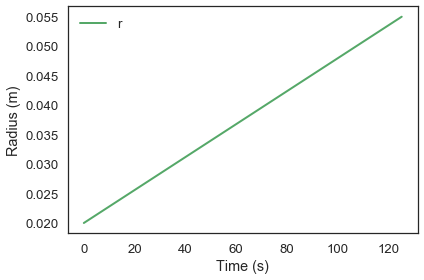

In [20]:
def plot_r(results):
    plot(results.r, color='C2', label='r')

    decorate(xlabel='Time (s)',
             ylabel='Radius (m)')
    
plot_r(results)

We can also see the relationship between `y` and `r`, which I derive analytically in the book.

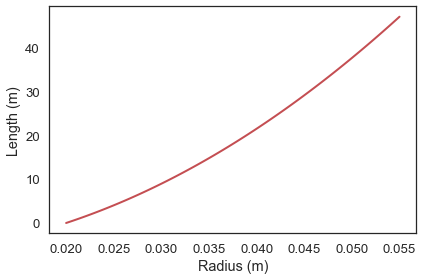

In [21]:
plot(results.r, results.y, color='C3')

decorate(xlabel='Radius (m)',
         ylabel='Length (m)',
         legend=False)

And here's the figure from the book.

Saving figure to file figs/chap24-fig01.pdf


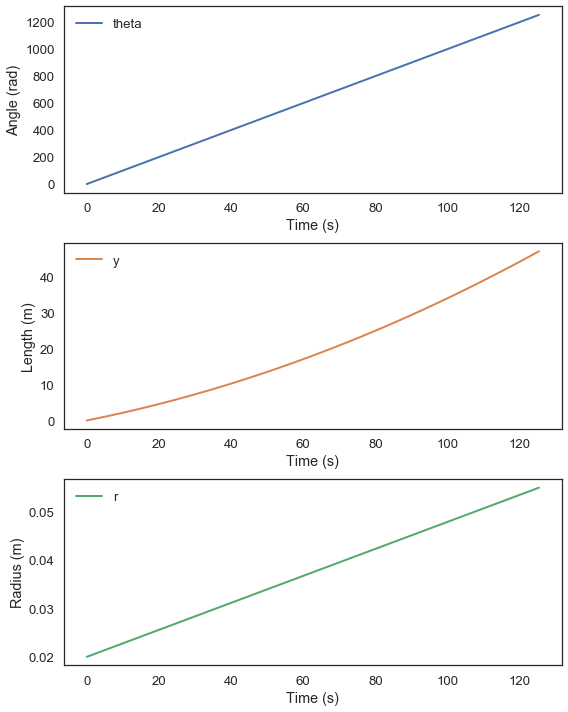

In [22]:
def plot_three(results):
    subplot(3, 1, 1)
    plot_theta(results)

    subplot(3, 1, 2)
    plot_y(results)

    subplot(3, 1, 3)
    plot_r(results)

plot_three(results)
savefig('figs/chap24-fig01.pdf')

### Animation

Here's a draw function that animates the results using `matplotlib` patches.

In [23]:
from matplotlib.patches import Circle
from matplotlib.patches import Arrow

def draw_func(state, t):
    # get radius in mm
    theta, y, r = state
    radius = r.magnitude * 1000
    
    # draw a circle with
    circle = Circle([0, 0], radius, fill=True)
    plt.gca().add_patch(circle)
    
    # draw an arrow to show rotation
    dx, dy = pol2cart(theta, radius)
    arrow = Arrow(0, 0, dx, dy)
    plt.gca().add_patch(arrow)

    # make the aspect ratio 1
    plt.axis('equal')

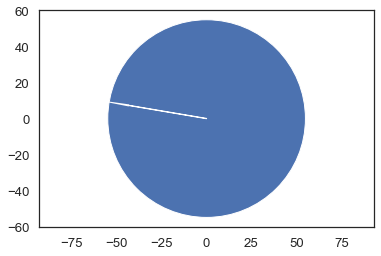

In [24]:
animate(results, draw_func)

**Exercise:** Run the simulation again with a smaller step size to smooth out the animation.

### Exercises

**Exercise:** Since we keep `omega` constant, the linear velocity of the paper increases with radius.  Use `gradient` to estimate the derivative of `results.y`.  What is the peak linear velocity?

In [25]:
# Solution

dydt = gradient(results.y);

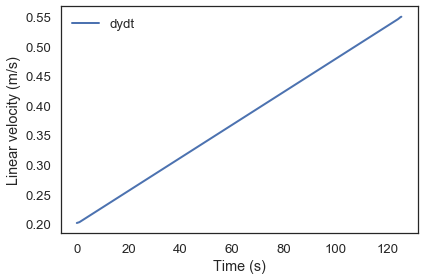

In [26]:
plot(dydt, label='dydt')
decorate(xlabel='Time (s)',
         ylabel='Linear velocity (m/s)')

In [27]:
# Solution

linear_velocity = get_last_value(dydt) * m/s

0.5504654255319086 <Unit('meter / second')>

Now suppose the peak velocity is the limit; that is, we can't move the paper any faster than that.

Nevertheless, we might be able to speed up the process by keeping the linear velocity at the maximum all the time.

Write a slope function that keeps the linear velocity, `dydt`, constant, and computes the angular velocity, `omega`, accordingly.

Run the simulation and see how much faster we could finish rolling the paper.

In [28]:
# Solution

def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: sequence of derivatives
    """
    theta, y, r = state
    k, omega = system.k, system.omega
    
    dydt = linear_velocity
    omega = dydt / r
    drdt = k * omega
    
    return omega, dydt, drdt

In [29]:
# Solution

slope_func(system.init, 0, system)

(27.523271276595427 <Unit('1 / second')>,
 0.5504654255319086 <Unit('meter / second')>,
 0.0007686019904368403 <Unit('meter / second')>)

In [30]:
# Solution

results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
success,True
message,A termination event occurred.


In [31]:
# Solution

t_final = get_last_label(results) * s

85.38229254741002 <Unit('second')>

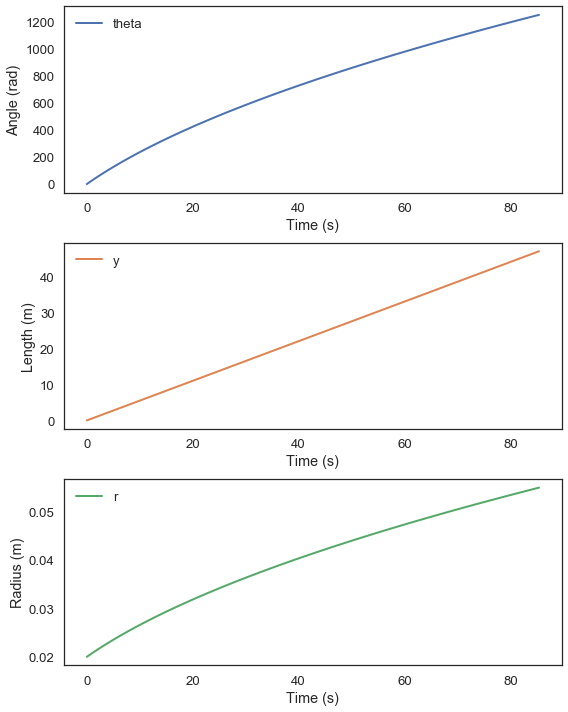

In [32]:
# Solution

plot_three(results)